# <center> Modelo de ML </center>

## 1. Librerías

In [2]:
import joblib
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from utils import evaluate_model
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split, StratifiedKFold

In [3]:
warnings.simplefilter('ignore')

## 2. Configuraciones

In [4]:
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

In [5]:
plt.rcParams["figure.figsize"] = (8, 5)
sns.set_theme(style = "whitegrid")

## 3. Carga de datos

In [6]:
DATA_PATH = "../Datasets/Refined/refined_data.csv"
df = pd.read_csv(DATA_PATH)

print("Shape:", df.shape)
df.head()

Shape: (9316, 10)


,codCliente,codPoliza,Ramo,Y,Salud,Vida,Autos,Cumplimiento,Patrimoniales,Otros
0,37,69,Vida,Autos,0,1,0,0,0,0
1,37,80568,Autos,Salud,0,1,1,0,0,0
2,84,118023,Autos,Vida,0,0,1,0,0,0
3,87,54,Vida,Salud,0,1,0,0,0,0
4,1356,206,Cumplimiento,Patrimoniales,0,0,0,1,0,0


## 4. Preprocesamiento de datos

### 4.1. Eliminar columnas de ID

In [7]:
id_cols = ["codCliente", "codPoliza"]
for col in id_cols:
    if col in df.columns:
        df = df.drop(columns = col)

### 4.2. Revisar desbalance entre clases

In [8]:
print(df["Y"].value_counts(normalize = True))

Y
Salud            0.285316
Patrimoniales    0.263847
Vida             0.223916
Autos            0.197939
Cumplimiento     0.022112
Otros            0.006870
Name: proportion, dtype: float64


### 4.3. Revisar nulos

In [9]:
df.isna().sum()

Ramo             0
Y                0
Salud            0
Vida             0
Autos            0
Cumplimiento     0
Patrimoniales    0
Otros            0
dtype: int64

## 5. Definición features y target

In [10]:
TARGET = "Y"

X = df.copy().drop(columns = TARGET)
y = df[TARGET].copy()

categorical_features = ["Ramo"]
numeric_features = [c for c in X.columns if c not in categorical_features]

X.head()

,Ramo,Salud,Vida,Autos,Cumplimiento,Patrimoniales,Otros
0,Vida,0,1,0,0,0,0
1,Autos,0,1,1,0,0,0
2,Autos,0,0,1,0,0,0
3,Vida,0,1,0,0,0,0
4,Cumplimiento,0,0,0,1,0,0


## 6. División del conjunto de datos

In [11]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size = 0.20,
    stratify = y,
    random_state = RANDOM_STATE,
)

print("Train size:", X_train.shape[0])
print("Test size: ", X_test.shape[0])

Train size: 7452
Test size:  1864


## 7. Pipelines de preprocesamiento

In [12]:
cv = StratifiedKFold(n_splits = 5, shuffle = True, random_state = RANDOM_STATE)

preprocess_for_linear = ColumnTransformer(
    transformers = [
        ("preprocess_categorical_features", OneHotEncoder(handle_unknown = "ignore"), categorical_features),
        ("preprocess_numeric_features", StandardScaler(), numeric_features),
    ]
)

preprocess_for_trees = ColumnTransformer(
    transformers = [
        ("preprocess_categorical_features", OneHotEncoder(handle_unknown = "ignore"), categorical_features),
        ("preprocess_numeric_features", "passthrough", numeric_features),
    ]
)

## 8. Modelos

### 8.1. Regresión logística

#### 8.1.1. Definición modelo

In [13]:
logreg_pipeline = Pipeline(
    steps = [
        ("preprocess", preprocess_for_linear),
        ("model", LogisticRegression(
            max_iter = 1000,
            multi_class = "multinomial",
            n_jobs = -1,
            random_state = RANDOM_STATE,
        )),
    ]
)

#### 8.1.2. Ajuste de hiperparámetros

In [14]:
logreg_param_grid = {
    "model__C": [0.01, 0.1, 1.0, 10.0],
    "model__solver": ["lbfgs", "saga"],
}

logreg_grid_search = GridSearchCV(
    estimator = logreg_pipeline,
    param_grid = logreg_param_grid,
    cv = cv, 
    scoring = {
        "f1_macro": "f1_macro",
        "top_k_accuracy": "top_k_accuracy",
    },
    refit = "f1_macro",
    n_jobs = -1,
    verbose = 2,
)

print("Running GridSearchCV for Logistic Regression...")
logreg_grid_search.fit(X_train, y_train)

Running GridSearchCV for Logistic Regression...
Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV] END .................model__C=0.01, model__solver=lbfgs; total time=   0.4s
[CV] END .................model__C=0.01, model__solver=lbfgs; total time=   0.4s
[CV] END .................model__C=0.01, model__solver=lbfgs; total time=   0.4s
[CV] END .................model__C=0.01, model__solver=lbfgs; total time=   0.4s
[CV] END .................model__C=0.01, model__solver=lbfgs; total time=   0.4s
[CV] END ..................model__C=0.1, model__solver=lbfgs; total time=   0.3s
[CV] END ..................model__C=0.1, model__solver=lbfgs; total time=   0.3s
[CV] END ..................model__C=0.01, model__solver=saga; total time=   0.9s
[CV] END ..................model__C=0.1, model__solver=lbfgs; total time=   0.3s
[CV] END ..................model__C=0.01, model__solver=saga; total time=   0.8s
[CV] END ..................model__C=0.01, model__solver=saga; total time=   0.8s
[

,estimator,Pipeline(step...m_state=42))])
,param_grid,"{'model__C': [0.01, 0.1, ...], 'model__solver': ['lbfgs', 'saga']}"
,scoring,"{'f1_macro': 'f1_macro', 'top_k_accuracy': 'top_k_accuracy'}"
,n_jobs,-1
,refit,'f1_macro'
,cv,StratifiedKFo... shuffle=True)
,verbose,2
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,transformers,"[('preprocess_categorical_features', ...), ('preprocess_numeric_features', ...)]"


#### 8.1.3. Entrenamiento mejor modelo

Accuracy (k=1): 0.5437
F1-macro: 0.3389

Classification report:
               precision    recall  f1-score   support

        Autos       0.57      0.13      0.21      1475
 Cumplimiento       0.00      0.00      0.00       165
        Otros       1.00      0.02      0.04        51
Patrimoniales       0.80      0.50      0.61      1966
        Salud       0.49      0.86      0.63      2126
         Vida       0.48      0.64      0.55      1669

     accuracy                           0.54      7452
    macro avg       0.56      0.36      0.34      7452
 weighted avg       0.58      0.54      0.50      7452


Top-k metrics:
acc@1: 0.5437 | prec@1: 0.5437 | recall@1: 0.5437
acc@2: 0.8219 | prec@2: 0.4110 | recall@2: 0.8219
acc@3: 0.9725 | prec@3: 0.3242 | recall@3: 0.9725
acc@5: 1.0000 | prec@5: 0.2000 | recall@5: 1.0000


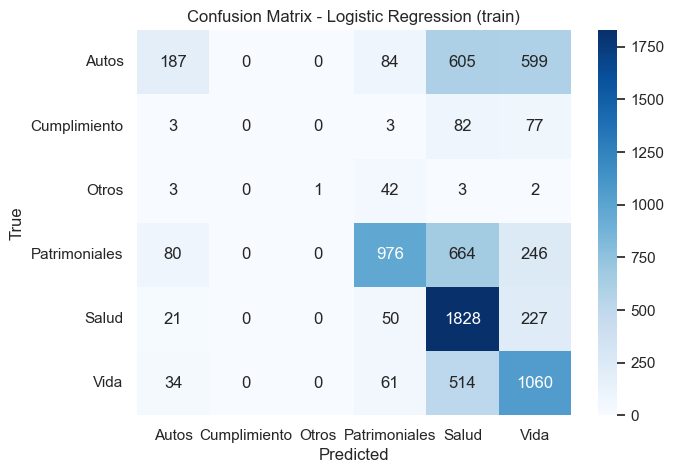

In [15]:
best_logreg_model = logreg_grid_search.best_estimator_
best_logreg_model.fit(X_train, y_train)

joblib.dump(best_logreg_model, "Best Models/best_logreg_model.pkl")

logreg_train_results = evaluate_model("Logistic Regression (train)", best_logreg_model, X_train, y_train)

#### 8.1.4. Evaluación mejor modelo

Accuracy (k=1): 0.5461
F1-macro: 0.3503

Classification report:
               precision    recall  f1-score   support

        Autos       0.67      0.17      0.28       369
 Cumplimiento       1.00      0.02      0.05        41
        Otros       0.00      0.00      0.00        13
Patrimoniales       0.83      0.49      0.62       492
        Salud       0.47      0.85      0.61       532
         Vida       0.50      0.63      0.56       417

     accuracy                           0.55      1864
    macro avg       0.58      0.36      0.35      1864
 weighted avg       0.62      0.55      0.52      1864


Top-k metrics:
acc@1: 0.5461 | prec@1: 0.5461 | recall@1: 0.5461
acc@2: 0.8192 | prec@2: 0.4096 | recall@2: 0.8192
acc@3: 0.9678 | prec@3: 0.3226 | recall@3: 0.9678
acc@5: 1.0000 | prec@5: 0.2000 | recall@5: 1.0000


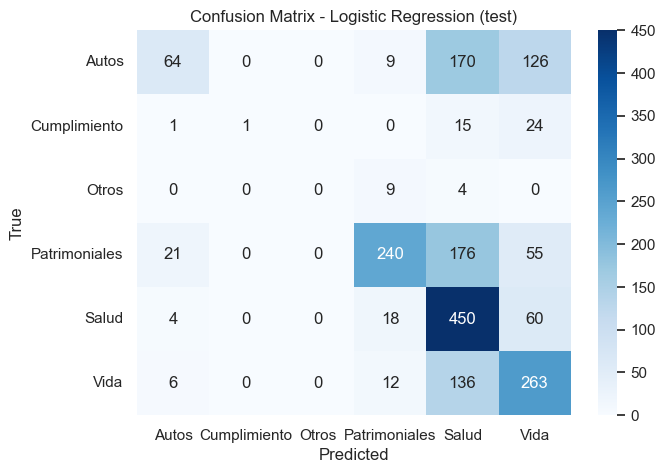

In [16]:
logreg_test_results = evaluate_model("Logistic Regression (test)", best_logreg_model, X_test, y_test)

### 8.2. HistGradientBoostingClassifier

#### 8.2.1. Definición del modelo

In [17]:
hgb_pipeline = Pipeline(
    steps = [
        ("preprocess", preprocess_for_trees),
        ("model", HistGradientBoostingClassifier(random_state = RANDOM_STATE)),
    ]
)

#### 8.2.2. Ajuste de hiperparámetros

In [18]:
param_grid = {
    "model__max_depth": [None, 6, 10],
    "model__learning_rate": [0.05, 0.1],
    "model__max_iter": [200, 400],
    "model__min_samples_leaf": [20, 50],
}

grid_search_hgb = GridSearchCV(
    estimator = hgb_pipeline,
    param_grid = param_grid,
    cv = cv,
    scoring = {
        "f1_macro": "f1_macro",
        "top_k_accuracy": "top_k_accuracy",
    },
    refit = "f1_macro",
    n_jobs = -1,
    verbose = 2,
)

print("Running GridSearchCV for HistGradientBoosting...")
grid_search_hgb.fit(X_train, y_train)

Running GridSearchCV for HistGradientBoosting...
Fitting 5 folds for each of 24 candidates, totalling 120 fits
[CV] END model__learning_rate=0.05, model__max_depth=None, model__max_iter=200, model__min_samples_leaf=50; total time=   7.5s
[CV] END model__learning_rate=0.05, model__max_depth=None, model__max_iter=200, model__min_samples_leaf=50; total time=   7.5s
[CV] END model__learning_rate=0.05, model__max_depth=None, model__max_iter=200, model__min_samples_leaf=50; total time=   7.6s
[CV] END model__learning_rate=0.05, model__max_depth=None, model__max_iter=200, model__min_samples_leaf=20; total time=   9.1s
[CV] END model__learning_rate=0.05, model__max_depth=None, model__max_iter=200, model__min_samples_leaf=20; total time=   9.1s
[CV] END model__learning_rate=0.05, model__max_depth=None, model__max_iter=200, model__min_samples_leaf=20; total time=   9.1s
[CV] END model__learning_rate=0.05, model__max_depth=None, model__max_iter=200, model__min_samples_leaf=20; total time=   9.1s


,estimator,Pipeline(step...m_state=42))])
,param_grid,"{'model__learning_rate': [0.05, 0.1], 'model__max_depth': [None, 6, ...], 'model__max_iter': [200, 400], 'model__min_samples_leaf': [20, 50]}"
,scoring,"{'f1_macro': 'f1_macro', 'top_k_accuracy': 'top_k_accuracy'}"
,n_jobs,-1
,refit,'f1_macro'
,cv,StratifiedKFo... shuffle=True)
,verbose,2
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,transformers,"[('preprocess_categorical_features', ...), ('preprocess_numeric_features', ...)]"


#### 8.2.3. Entrenamiento mejor modelo

Accuracy (k=1): 0.5452
F1-macro: 0.3434

Classification report:
               precision    recall  f1-score   support

        Autos       0.57      0.13      0.21      1475
 Cumplimiento       0.00      0.00      0.00       165
        Otros       1.00      0.02      0.04        51
Patrimoniales       0.81      0.49      0.61      1966
        Salud       0.55      0.64      0.59      2126
         Vida       0.45      0.91      0.60      1669

     accuracy                           0.55      7452
    macro avg       0.56      0.37      0.34      7452
 weighted avg       0.59      0.55      0.51      7452


Top-k metrics:
acc@1: 0.5452 | prec@1: 0.5452 | recall@1: 0.5452
acc@2: 0.8241 | prec@2: 0.4120 | recall@2: 0.8241
acc@3: 0.9725 | prec@3: 0.3242 | recall@3: 0.9725
acc@5: 1.0000 | prec@5: 0.2000 | recall@5: 1.0000


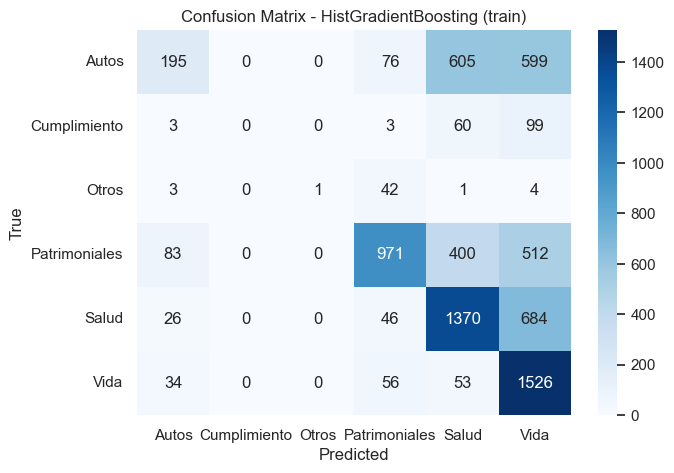

In [19]:
best_hgb_model = grid_search_hgb.best_estimator_
best_hgb_model.fit(X_train, y_train)

joblib.dump(best_hgb_model, "Best Models/best_hgb_model.pkl")


hgb_train_results = evaluate_model("HistGradientBoosting (train)", best_hgb_model, X_train, y_train)

#### 8.2.4. Evaluación mejor modelo

Accuracy (k=1): 0.5429
F1-macro: 0.3505

Classification report:
               precision    recall  f1-score   support

        Autos       0.64      0.18      0.28       369
 Cumplimiento       1.00      0.02      0.05        41
        Otros       0.00      0.00      0.00        13
Patrimoniales       0.85      0.48      0.61       492
        Salud       0.53      0.61      0.56       532
         Vida       0.45      0.92      0.60       417

     accuracy                           0.54      1864
    macro avg       0.58      0.37      0.35      1864
 weighted avg       0.62      0.54      0.51      1864


Top-k metrics:
acc@1: 0.5429 | prec@1: 0.5429 | recall@1: 0.5429
acc@2: 0.8165 | prec@2: 0.4083 | recall@2: 0.8165
acc@3: 0.9683 | prec@3: 0.3228 | recall@3: 0.9683
acc@5: 1.0000 | prec@5: 0.2000 | recall@5: 1.0000


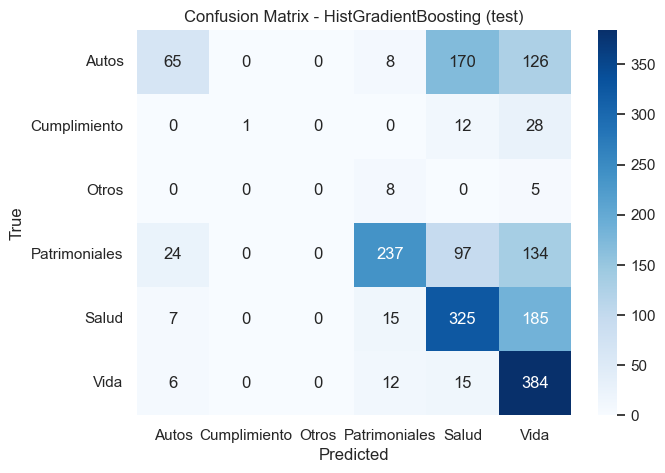

In [20]:
hgb_test_results = evaluate_model("HistGradientBoosting (test)", best_hgb_model, X_test, y_test)